# Installs

In [1]:
!pip -q install hyperopt

---

# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

import networkx as nx
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax
import functools

---

# Linear models

## Polynomial Regression

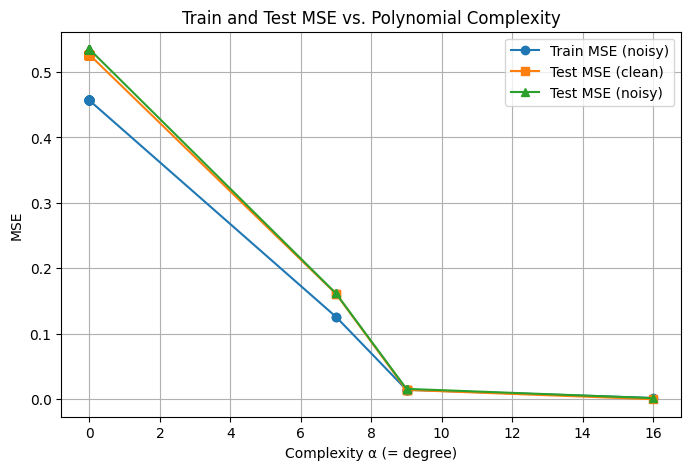

In [35]:
# Seed for reproducibility
np.random.seed(42)
random.seed(42)

# Generate sample data: sin(nπx) with noise
N = 200
x = np.linspace(0, 1, N)
y_clean = np.sin(6 * np.pi * x)
noise = np.random.normal(scale=0.05, size=N)
y_noisy = y_clean + noise

# Split into 60% train, 40% test
indices = list(range(N))
random.shuffle(indices)
split = int(0.6 * N)
train_idx = indices[:split]
test_idx = indices[split:]

# MSE for polynomial of degree d on given indices
def compute_mse(d, y, idx):
    coeffs = np.polyfit(x[idx], y[idx], d)
    y_pred = np.polyval(coeffs, x[idx])
    return np.mean((y[idx] - y_pred) ** 2)

# Annealing over d in [0,16] minimizing action on train data
def anneal(lam, d_max=16, T0=1.0, alpha=0.95, steps=2000):
    d = random.randint(0, d_max)
    T = T0
    mse_train = compute_mse(d, y_noisy, train_idx)
    for _ in range(steps):
        d2 = d + random.choice([-1, 1])
        if not (0 <= d2 <= d_max):
            continue
        mse2 = compute_mse(d2, y_noisy, train_idx)
        A1 = lam * (d + 1) + mse_train
        A2 = lam * (d2 + 1) + mse2
        if A2 < A1 or random.random() < math.exp(-(A2 - A1) / T):
            d, mse_train = d2, mse2
        T *= alpha
    return d, mse_train

# Sweep λ and collect train/test errors
lambdas = np.linspace(0, 1, 64)
alphas, train_errs, test_errs_clean, test_errs_noisy = [], [], [], []

for lam in lambdas:
    d_opt, mse_train = anneal(lam, d_max=16, T0=1.0, alpha=0.95, steps=1000)
    alphas.append(d_opt)
    train_errs.append(mse_train)
    # evaluate on test set against clean function
    test_errs_clean.append(compute_mse(d_opt, y_clean, test_idx))
    # evaluate on test set against noisy data
    test_errs_noisy.append(compute_mse(d_opt, y_noisy, test_idx))

alphas = np.array(alphas)
train_errs = np.array(train_errs)
test_errs_clean = np.array(test_errs_clean)
test_errs_noisy = np.array(test_errs_noisy)

idx = np.argsort(alphas)
alphas = alphas[idx]
train_errs = train_errs[idx]
test_errs_clean = test_errs_clean[idx]
test_errs_noisy = test_errs_noisy[idx]

# Plot training vs test MSE
plt.figure(figsize=(8, 5))
plt.plot(alphas, train_errs, marker='o', label='Train MSE (noisy)')
plt.plot(alphas, test_errs_clean, marker='s', label='Test MSE (clean)')
plt.plot(alphas, test_errs_noisy, marker='^', label='Test MSE (noisy)')
plt.xlabel('Complexity α (= degree)')
plt.ylabel('MSE')
plt.title('Train and Test MSE vs. Polynomial Complexity')
plt.legend()
plt.grid(True)
plt.show()

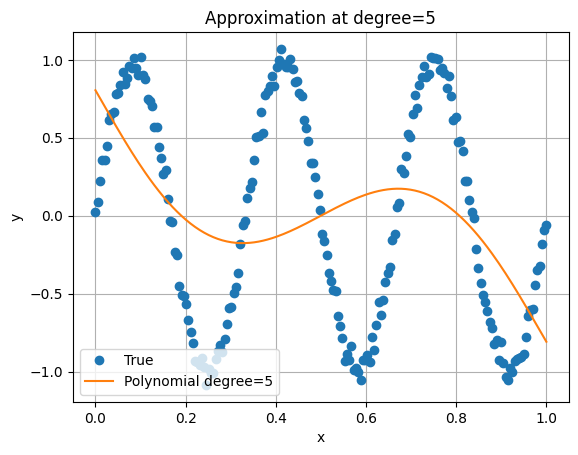

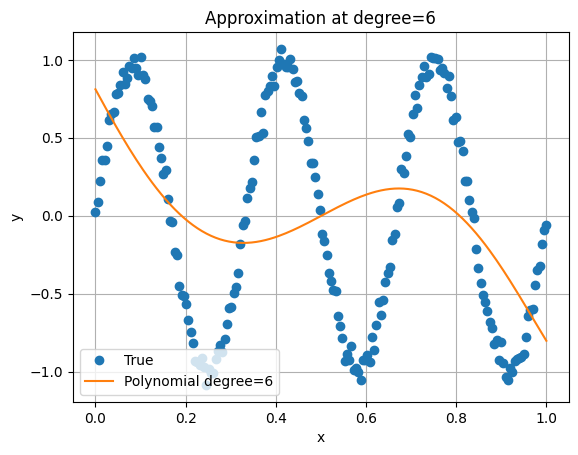

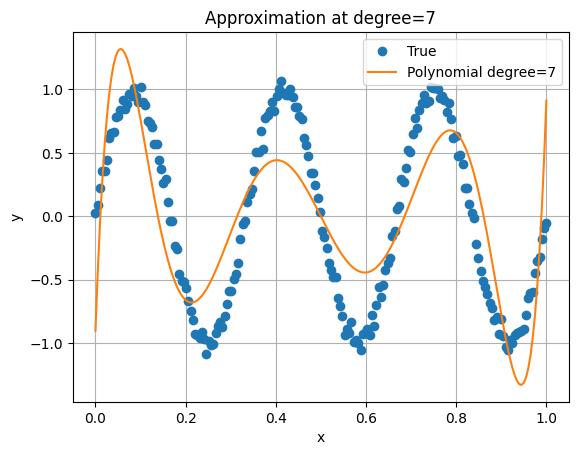

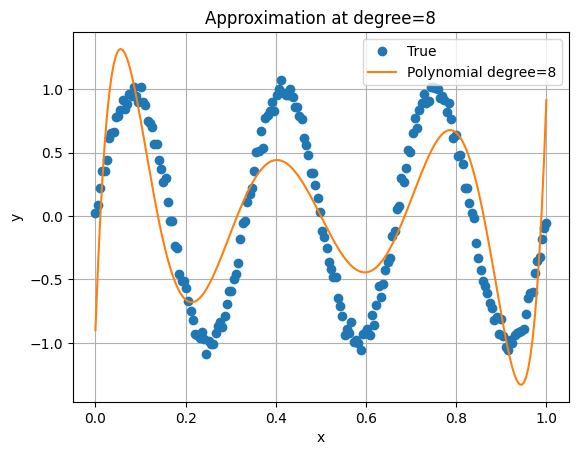

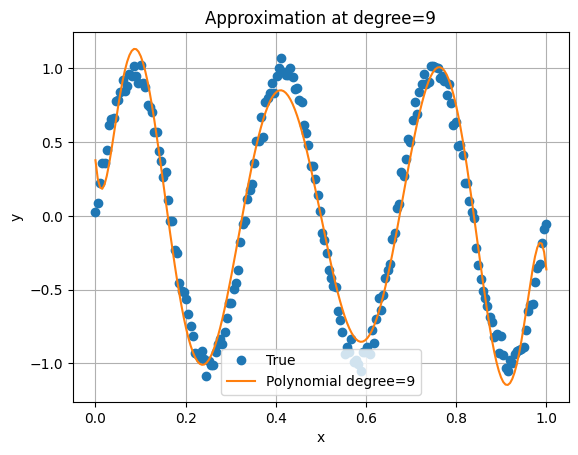

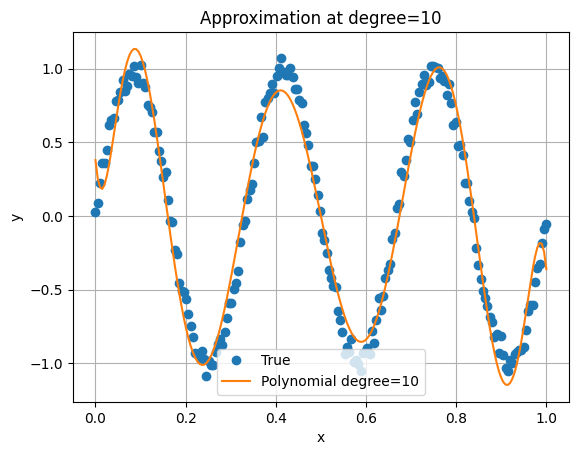

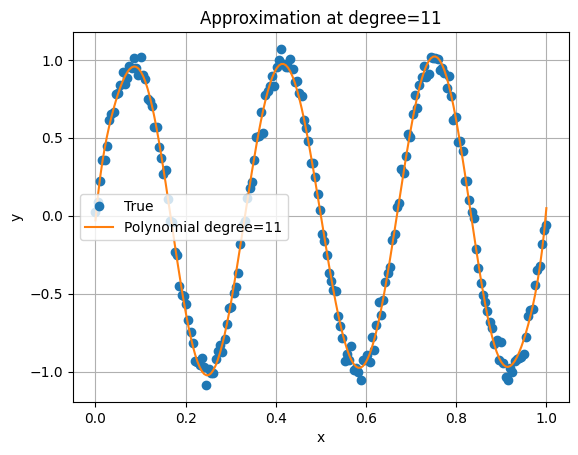

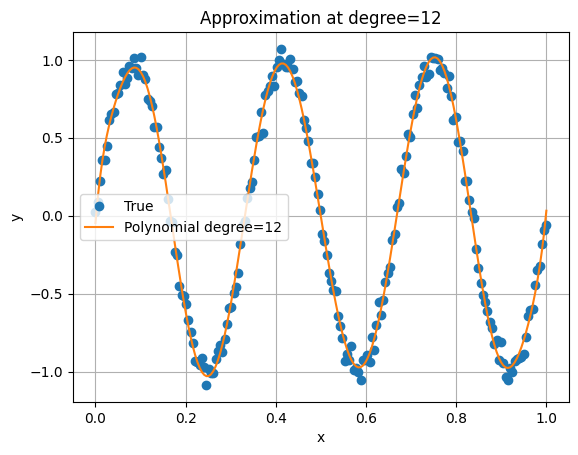

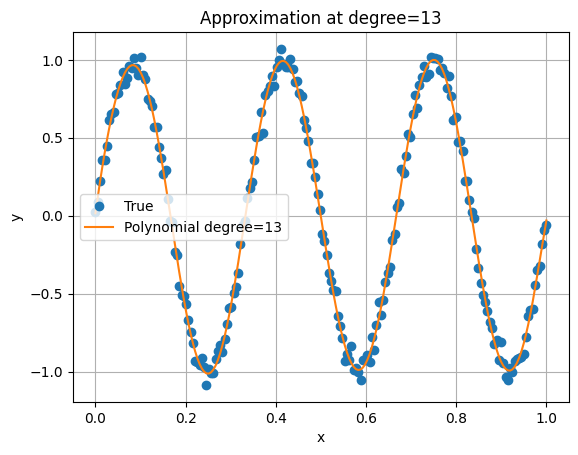

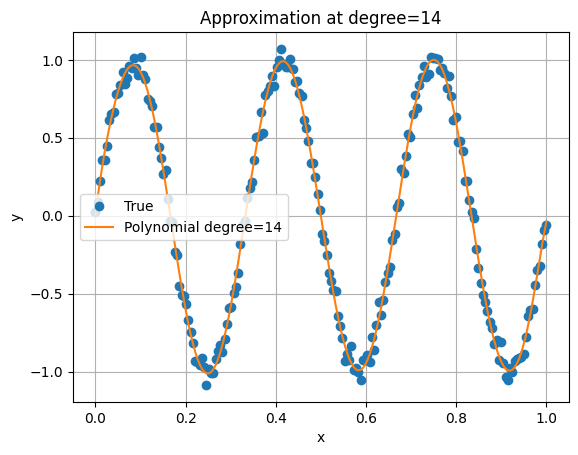

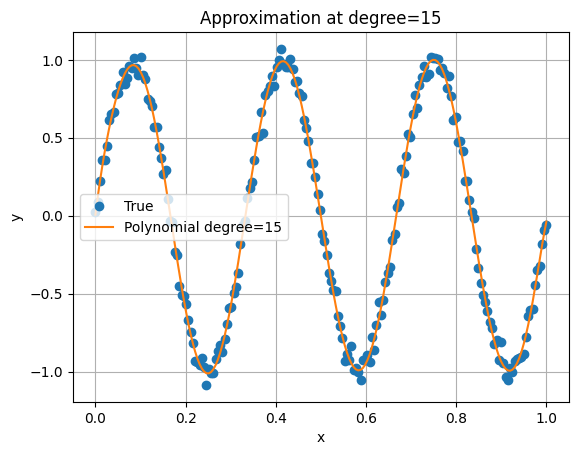

In [36]:
def plot_approximation(degree, x, y):
    # Fit polynomial and predict
    coeffs = np.polyfit(x, y, degree)
    y_pred = np.polyval(coeffs, x)
    # Plot
    plt.figure()
    plt.plot(x, y, marker='o', linestyle='None', label='True')
    plt.plot(x, y_pred, label=f'Polynomial degree={degree}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Approximation at degree={degree}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for degrees
for deg in range(5,16):
    plot_approximation(deg, x, y_noisy)

## Fourier Series

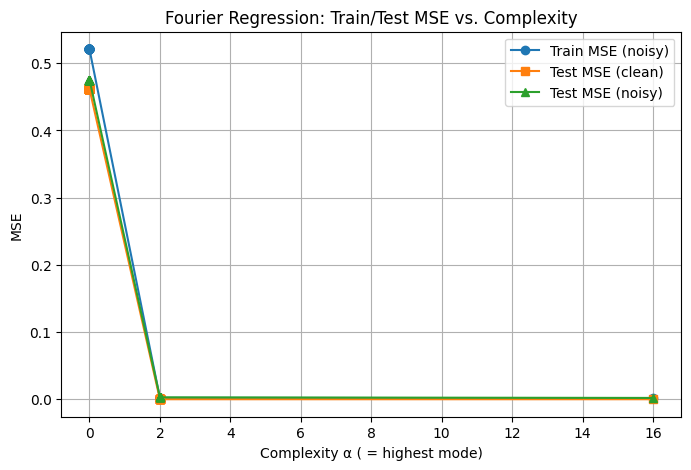

In [37]:
# Seed for reproducibility
np.random.seed(0)
random.seed(0)

# Generate data
N = 200
x = np.linspace(0, 1, N)
y_clean = np.sin(4 * np.pi * x)
noise_train = np.random.normal(scale=0.05, size=N)
y_noisy = y_clean + noise_train

# Split into 60% train, 40% test
indices = np.arange(N)
np.random.shuffle(indices)
split = int(0.6 * N)
train_idx = indices[:split]
test_idx = indices[split:]

x_train, y_train = x[train_idx], y_noisy[train_idx]
x_test, y_test = x[test_idx], y_clean[test_idx]  # test against clean

# Build Fourier features
def fourier_design(x, K):
    # features: [1, sin(2πk x), cos(2πk x) for k=1..K]
    F = [np.ones_like(x)]
    for k in range(1, K+1):
        F.append(np.sin(2 * np.pi * k * x))
        F.append(np.cos(2 * np.pi * k * x))
    return np.vstack(F).T

# MSE for Fourier model of complexity K
def compute_mse_fourier(K, x_, y_):
    X = fourier_design(x_, K)
    coeffs, *_ = np.linalg.lstsq(X, y_, rcond=None)
    y_pred = X.dot(coeffs)
    return np.mean((y_ - y_pred)**2)

# Annealing: choose K in [0..16]
def anneal_fourier(lam, K_max=16, T0=1.0, alpha=0.95, steps=2000):
    K = random.randint(0, K_max)
    T = T0
    mse = compute_mse_fourier(K, x_train, y_train)
    for _ in range(steps):
        K2 = K + random.choice([-1, 1])
        if not (0 <= K2 <= K_max): continue
        mse2 = compute_mse_fourier(K2, x_train, y_train)
        A1 = lam * (2*K+1) + mse
        A2 = lam * (2*K2+1) + mse2
        if A2 < A1 or random.random() < math.exp(-(A2 - A1) / T):
            K, mse = K2, mse2
        T *= alpha
    return K, mse

# Sweep λ and measure train/test MSE
lambdas = np.linspace(0, 1, 64)
alphas, train_errs, test_errs_clean, test_errs_noisy = [], [], [], []

for lam in lambdas:
    K_opt, mse_tr = anneal_fourier(lam, K_max=16)
    alphas.append(K_opt)
    train_errs.append(mse_tr)
    # evaluate on test set against clean function
    test_errs_clean.append(compute_mse_fourier(K_opt, x_test, y_test))
    # evaluate on test set against noisy data
    test_errs_noisy.append(compute_mse_fourier(K_opt, x_test, y_noisy[test_idx]))

alphas = np.array(alphas)
train_errs = np.array(train_errs)
test_errs_clean = np.array(test_errs_clean)
test_errs_noisy = np.array(test_errs_noisy)

idx = np.argsort(alphas)
alphas = alphas[idx]
train_errs = train_errs[idx]
test_errs_clean = test_errs_clean[idx]
test_errs_noisy = test_errs_noisy[idx]

# Plot training vs test MSE
plt.figure(figsize=(8, 5))
plt.plot(alphas, train_errs, marker='o', label='Train MSE (noisy)')
plt.plot(alphas, test_errs_clean, marker='s', label='Test MSE (clean)')
plt.plot(alphas, test_errs_noisy, marker='^', label='Test MSE (noisy)')
plt.xlabel('Complexity α ( = highest mode)')
plt.ylabel('MSE')
plt.title('Fourier Regression: Train/Test MSE vs. Complexity')
plt.legend()
plt.grid(True)
plt.show()

---

# Tree-based models

## Tree regressor with Simulated Annealing

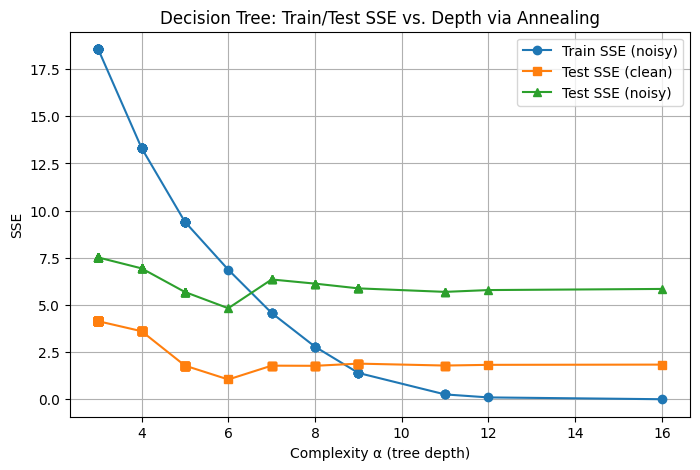

In [55]:
# Seed for reproducibility
np.random.seed(42)
random.seed(42)

# Generate data
N = 200
x = np.linspace(0, 1, N).reshape(-1, 1)
y_clean = np.sin(4 * np.pi * x).ravel()

# Add independent noise to create train/test labels
noise_train = np.random.normal(scale=0.3, size=N)
noise_test = np.random.normal(scale=0.3, size=N)

# Split indices (80% train, 20% test)
indices = np.arange(N)
np.random.shuffle(indices)
split = int(0.8 * N)
train_idx = indices[:split]
test_idx = indices[split:]

x_train, y_train_noisy = x[train_idx], y_clean[train_idx] + noise_train[train_idx]
x_test, y_test_clean, y_test_noisy = x[test_idx], y_clean[test_idx], y_clean[test_idx] + noise_test[test_idx]

# SSE computation

# Noisy train SSE computation
def sse_train(depth):
    dt = DecisionTreeRegressor(max_depth=depth)
    dt.fit(x_train, y_train_noisy)
    preds = dt.predict(x_train)
    return np.sum((y_train_noisy - preds) ** 2)

# Clean test SSE computation (for comparison)
def sse_test_clean(depth):
    dt = DecisionTreeRegressor(max_depth=depth)
    dt.fit(x_train, y_train_noisy)
    preds = dt.predict(x_test)
    return np.sum((y_test_clean - preds) ** 2)

# Noisy test SSE computation (for actual loss)
def sse_test_noisy(depth):
    dt = DecisionTreeRegressor(max_depth=depth)
    dt.fit(x_train, y_train_noisy)
    preds = dt.predict(x_test)
    return np.sum((y_test_noisy - preds) ** 2)

# Annealing over tree depth
def anneal_tree(lam, depth_max=16, T0=1.0, alpha=0.95, steps=2000):
    depth = random.randint(1, depth_max)
    T = T0
    sse_tr = sse_train(depth)
    for _ in range(steps):
        depth2 = depth + random.choice([-1, 1])
        if not (1 <= depth2 <= depth_max):
            continue
        sse2 = sse_train(depth2)
        A1 = lam * depth + sse_tr
        A2 = lam * depth2 + sse2
        if A2 < A1 or random.random() < math.exp(-(A2 - A1) / T):
            depth, sse_tr = depth2, sse2
        T *= alpha
    return depth, sse_tr

# Sweep lambda to find optimal depth, record SSE
lambdas = np.linspace(0, 8, 64)
alphas = []
train_errs = []
test_errs_clean = []
test_errs_noisy = []

for lam in lambdas:
    d_opt, sse_tr = anneal_tree(lam)
    alphas.append(d_opt)
    train_errs.append(sse_tr)
    test_errs_clean.append(sse_test_clean(d_opt))
    test_errs_noisy.append(sse_test_noisy(d_opt))

alphas = np.array(alphas)
train_errs = np.array(train_errs)
test_errs_clean = np.array(test_errs_clean)
test_errs_noisy = np.array(test_errs_noisy)

idx = np.argsort(alphas)
alphas = alphas[idx]
train_errs = train_errs[idx]
test_errs_clean = test_errs_clean[idx]
test_errs_noisy = test_errs_noisy[idx]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(alphas, train_errs, marker='o', label='Train SSE (noisy)')
plt.plot(alphas, test_errs_clean, marker='s', label='Test SSE (clean)')
plt.plot(alphas, test_errs_noisy, marker='^', label='Test SSE (noisy)')
plt.xlabel('Complexity α (tree depth)')
plt.ylabel('SSE')
plt.title('Decision Tree: Train/Test SSE vs. Depth via Annealing')
plt.legend()
plt.grid(True)
plt.show()

## Tree Regressor with HyperOpt

100%|██████████| 50/50 [00:00<00:00, 287.79trial/s, best loss: 6.744421693667917]


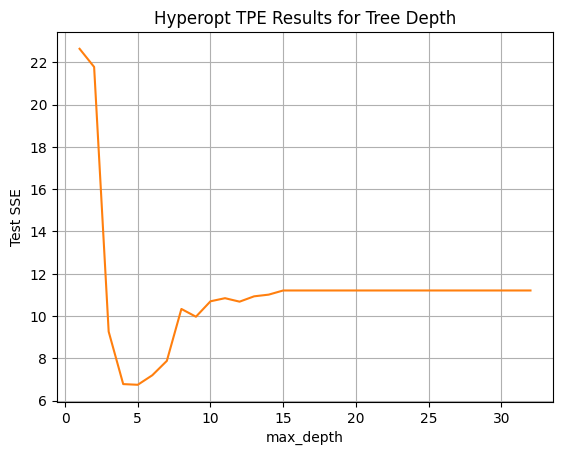

Best depth: 5


In [19]:
# Generate data
N = 200
x = np.linspace(0, 1, N).reshape(-1, 1)
y_clean = np.sin(4 * np.pi * x).ravel()

# Add independent noise to create train/test labels
noise_train = np.random.normal(scale=0.3, size=N)
noise_test = np.random.normal(scale=0.3, size=N)

# Split indices (80% train, 20% test)
indices = np.arange(N)
np.random.shuffle(indices)
split = int(0.8 * N)
train_idx = indices[:split]
test_idx = indices[split:]

x_train, y_train_noisy = x[train_idx], y_clean[train_idx] + noise_train[train_idx]
x_test, y_test_clean, y_test_noisy = x[test_idx], y_clean[test_idx], y_clean[test_idx] + noise_test[test_idx]

# Objective for Hyperopt: fit DT, return *noisy* test SSE
def objective(params):
    d = int(params['max_depth'])
    model = DecisionTreeRegressor(max_depth=d, random_state=0)
    model.fit(x_train, y_train_noisy)
    preds = model.predict(x_test)
    sse = np.sum((y_test_noisy - preds)**2)
    return {'loss': sse, 'status': STATUS_OK}

# Search space: depths 1..30
space = {'max_depth': hp.quniform('max_depth', 1, 32, 1)}

# Run TPE for, say, 50 evaluations
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.default_rng(42)
)

# Extract results
depths = [int(t['misc']['vals']['max_depth'][0]) for t in trials.trials]
losses = [t['result']['loss'] for t in trials.trials]
depths = np.array(depths)
losses = np.array(losses)
idx = np.argsort(depths)
depths = depths[idx]
losses = losses[idx]

# Plot test MSE vs chosen depth
plt.plot(depths, losses, c='C1')
plt.xlabel('max_depth')
plt.ylabel('Test SSE')
plt.title('Hyperopt TPE Results for Tree Depth')
plt.grid(True)
plt.show()

print("Best depth:", int(best['max_depth']))

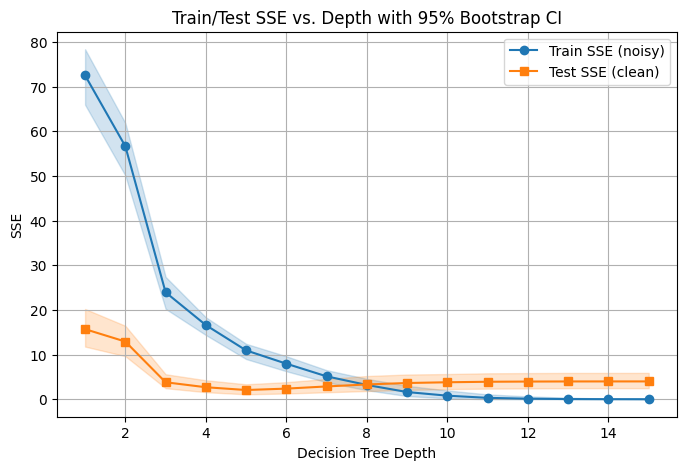

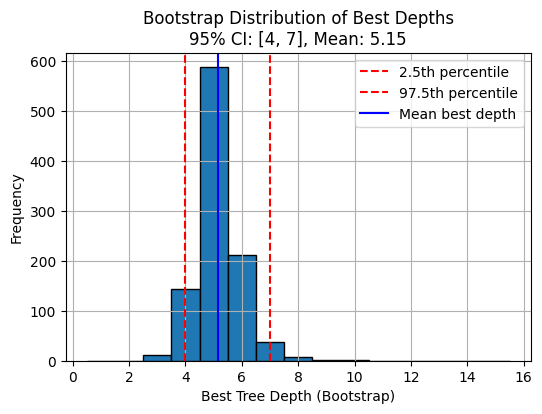

Bootstrap best depth mean = 5.15, 95% CI = [4, 7]


In [5]:
# Parameters
depths = np.arange(1, 16, 1)
B = 1000  # number of bootstrap replicates

# Arrays to store bootstrap SSE and best depths
sse_train = np.zeros((B, depths.size))
sse_test = np.zeros((B, depths.size))
best_depths = np.zeros(B, dtype=int)

for b in range(B):
    # Bootstrap indices for train and test sets
    indices = np.arange(N)
    np.random.shuffle(indices)
    split = int(0.8 * N)
    train_idx = indices[:split]
    test_idx = indices[split:]

    x_train, y_train_noisy = x[train_idx], y_clean[train_idx] + noise_train[train_idx]
    x_test, y_test_clean, y_test_noisy = x[test_idx], y_clean[test_idx], y_clean[test_idx] + noise_test[test_idx]

    for i, d in enumerate(depths):
        model = DecisionTreeRegressor(max_depth=d, random_state=0)
        # Fit on bootstrapped train data (noisy)
        model.fit(x_train, y_train_noisy)
        # Predict on train and test
        y_pred_train = model.predict(x_train)
        y_pred_test = model.predict(x_test)
        # Compute SSE
        sse_train[b, i] = np.sum((y_train_noisy - y_pred_train) ** 2)
        sse_test[b, i] = np.sum((y_test_clean - y_pred_test) ** 2)

    # Best depth for this bootstrap replicate (min *noisy* test SSE)
    best_depths[b] = depths[np.argmin(sse_test[b])]

# Compute SSE statistics
train_sse_mean = sse_train.mean(axis=0)
train_sse_lower = np.percentile(sse_train, 2.5, axis=0)
train_sse_upper = np.percentile(sse_train, 97.5, axis=0)
test_sse_mean = sse_test.mean(axis=0)
test_sse_lower = np.percentile(sse_test, 2.5, axis=0)
test_sse_upper = np.percentile(sse_test, 97.5, axis=0)

# Compute best-depth CI
ci_lower = np.percentile(best_depths, 2.5)
ci_upper = np.percentile(best_depths, 97.5)
mean_best_depth = best_depths.mean()

# Plot 1: MSE vs depth with 95% CI shading
plt.figure(figsize=(8, 5))
plt.plot(depths, train_sse_mean, marker='o', label='Train SSE (noisy)')
plt.fill_between(depths, train_sse_lower, train_sse_upper, color='C0', alpha=0.2)
plt.plot(depths, test_sse_mean, marker='s', label='Test SSE (clean)')
plt.fill_between(depths, test_sse_lower, test_sse_upper, color='C1', alpha=0.2)
plt.xlabel('Decision Tree Depth')
plt.ylabel('SSE')
plt.title('Train/Test SSE vs. Depth with 95% Bootstrap CI')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Histogram of best depths
plt.figure(figsize=(6, 4))
plt.hist(best_depths, bins=np.arange(depths.min(), depths.max()+2)-0.5, edgecolor='black')
plt.axvline(ci_lower, color='red', linestyle='--', label='2.5th percentile')
plt.axvline(ci_upper, color='red', linestyle='--', label='97.5th percentile')
plt.axvline(mean_best_depth, color='blue', linestyle='-', label='Mean best depth')
plt.xlabel('Best Tree Depth (Bootstrap)')
plt.ylabel('Frequency')
plt.title(f'Bootstrap Distribution of Best Depths\n95% CI: [{ci_lower:.0f}, {ci_upper:.0f}], Mean: {mean_best_depth:.2f}')
plt.legend()
plt.grid(True)
plt.show()

# Print CI results
print(f"Bootstrap best depth mean = {mean_best_depth:.2f}, 95% CI = [{ci_lower:.0f}, {ci_upper:.0f}]")


### Sum of Squared Errors (L2)

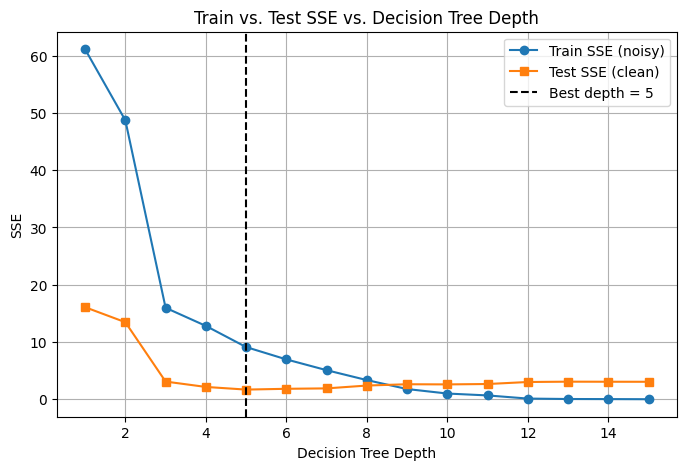

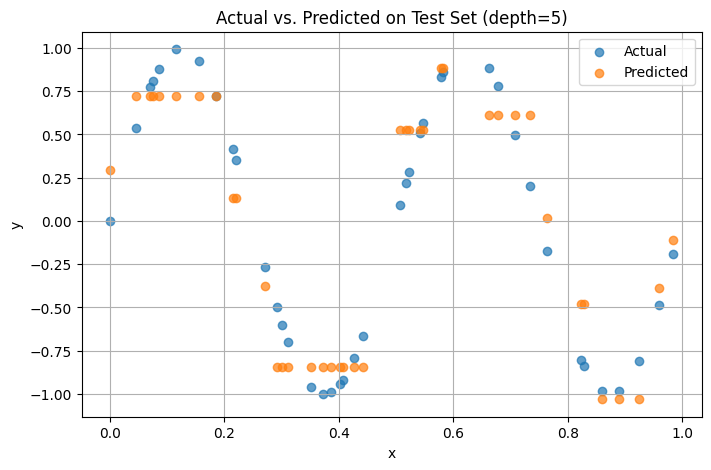

In [53]:
# Grid search over tree depths
max_depths = range(1, 16, 1)
train_sse = []
test_sse  = []

for d in max_depths:
    model = DecisionTreeRegressor(max_depth=d, random_state=0)
    model.fit(x_train, y_train_noisy)
    train_pred = model.predict(x_train)
    test_pred  = model.predict(x_test)
    train_sse.append(np.sum((y_train_noisy - train_pred)**2))
    test_sse.append(np.sum((y_test_clean - test_pred)**2))

# Identify best depth where test MSE is minimal
best_depth = max_depths[int(np.argmin(test_sse))]

# Plot train/test MSE vs depth
plt.figure(figsize=(8, 5))
plt.plot(max_depths, train_sse, marker='o', label='Train SSE (noisy)')
plt.plot(max_depths, test_sse,  marker='s', label='Test SSE (clean)')
plt.axvline(best_depth, color='k', linestyle='--', label=f'Best depth = {best_depth}')
plt.xlabel('Decision Tree Depth')
plt.ylabel('SSE')
plt.title('Train vs. Test SSE vs. Decision Tree Depth')
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------------------------------------------
# New: Plot actual test data vs. predictions at best_depth
best_model    = DecisionTreeRegressor(max_depth=best_depth, random_state=0)
best_model.fit(x_train, y_train_noisy)
test_pred_best = best_model.predict(x_test)

plt.figure(figsize=(8, 5))
# scatter actual vs predicted
plt.scatter(x_test, y_test_clean,    label='Actual',    alpha=0.7)
plt.scatter(x_test, test_pred_best,   label='Predicted', alpha=0.7)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Actual vs. Predicted on Test Set (depth={best_depth})')
plt.legend()
plt.grid(True)
plt.show()


### Sum of Absolute Errors (L1)

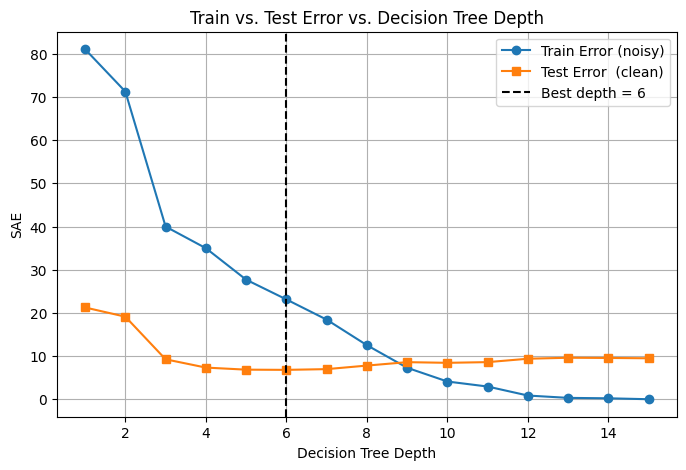

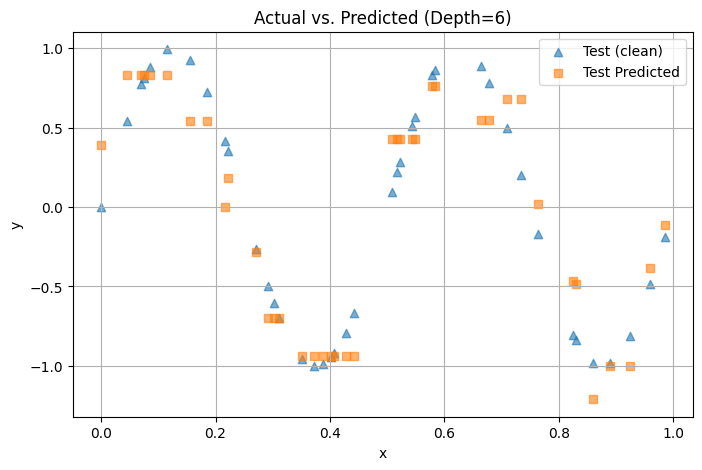

In [54]:
# Grid search over tree depths (using absolute error)
max_depths = range(1, 16, 1)
train_sae = []
test_sae  = []

for d in max_depths:
    model = DecisionTreeRegressor(max_depth=d, random_state=0)
    model.fit(x_train, y_train_noisy)
    train_pred = model.predict(x_train)
    test_pred  = model.predict(x_test)
    train_sae.append(np.sum(np.abs(y_train_noisy - train_pred)))
    test_sae.append(np.sum(np.abs(y_test_clean   - test_pred)))

# Identify best depth where test error is minimal
best_depth = max_depths[int(np.argmin(test_sae))]

# Plot train/test error vs depth
plt.figure(figsize=(8, 5))
plt.plot(max_depths, train_sae, marker='o', label='Train Error (noisy)')
plt.plot(max_depths, test_sae,  marker='s', label='Test Error  (clean)')
plt.axvline(best_depth, color='k', linestyle='--', label=f'Best depth = {best_depth}')
plt.xlabel('Decision Tree Depth')
plt.ylabel('SAE')
plt.title('Train vs. Test Error vs. Decision Tree Depth')
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------------------------------------------
# Plot actual vs. predicted on both test and noisy train data
best_model     = DecisionTreeRegressor(max_depth=best_depth, random_state=0)
best_model.fit(x_train, y_train_noisy)
test_pred_best = best_model.predict(x_test)
train_pred_best= best_model.predict(x_train)

plt.figure(figsize=(8, 5))
# noisy training data
#plt.scatter(x_train, y_train_noisy,    label='Train (noisy)',    alpha=0.6, marker='x')
# model's fit on training data
#plt.scatter(x_train, train_pred_best,  label='Train Predicted',  alpha=0.6, marker='o')
# clean test data
plt.scatter(x_test,  y_test_clean,     label='Test (clean)',     alpha=0.6, marker='^')
# model's predictions on test
plt.scatter(x_test,  test_pred_best,   label='Test Predicted',   alpha=0.6, marker='s')

plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Actual vs. Predicted (Depth={best_depth})')
plt.legend()
plt.grid(True)
plt.show()


# Deep Neural Net based on a DAG with lateral and skip connections

100%|██████████| 50/50 [11:48<00:00, 14.18s/trial, best loss: 0.008808286860585213]
Best trial #27: MSE=0.0088, Complexity=1096.17
Hyperparams: layers=5, nodes/layer=8, width=32, lr=6.7e-02, epochs=200


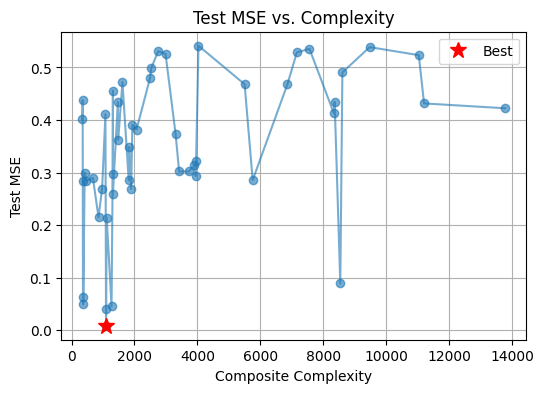

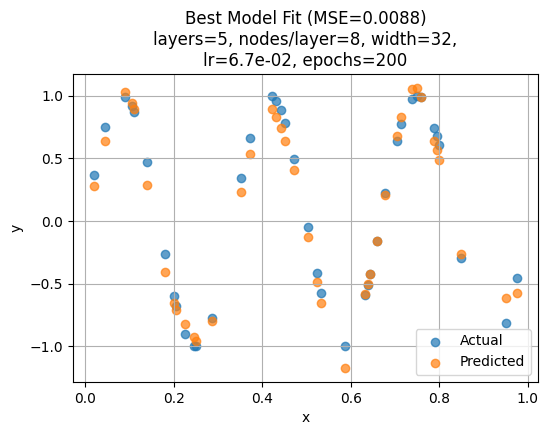

In [7]:
# === Globals to store each trial's model, DAG, and complexity ===
trained_models   = []  # list of (params, apply_fn)
trained_dags     = []
complexity_list  = []
loss_list        = []

# Synthetic regression data
N = 200
x = np.linspace(0, 1, N).reshape(-1, 1)
y_clean = np.sin(6 * np.pi * x).ravel()
noise = np.random.normal(scale=0.3, size=N)
idx = np.arange(N); np.random.shuffle(idx)

# Train / test split with 80% for train and 20% for test datasets
split = int(0.8 * N)
train_idx, test_idx = idx[:split], idx[split:]
x_train, y_train = x[train_idx], y_clean[train_idx] + noise[train_idx]
x_test,  y_test  = x[test_idx],  y_clean[test_idx]

# Layered DAG builder
def make_layered_dag(L, M, p_lat, p_skip, seed=0):
    rng = np.random.RandomState(seed)
    D = nx.DiGraph()
    for layer in range(L):
        for node in range(M):
            D.add_node((layer, node))
    for layer in range(L - 1):
        for i in range(M):
            for j in range(M):
                D.add_edge((layer, i), (layer + 1, j))
    for layer in range(L):
        for i in range(M):
            for j in range(i + 1, M):
                if rng.rand() < p_lat:
                    D.add_edge((layer, i), (layer, j))
    for layer in range(L):
        for target in range(layer + 2, L):
            for i in range(M):
                for j in range(M):
                    if rng.rand() < p_skip:
                        D.add_edge((layer, i), (target, j))
    D.add_node("IN"); D.add_node("OUT")
    for i in range(M):
        D.add_edge("IN", (0, i))
        D.add_edge((L - 1, i), "OUT")
    return D

# Flax graph‐structured network factory
def make_graphnet(adj, width, act=nn.relu):
    class GraphNet(nn.Module):
        @nn.compact
        def __call__(self, x):
            h = {"IN": x}
            for node in nx.topological_sort(adj):
                if node in ("IN", "OUT"):
                    continue
                parents = list(adj.predecessors(node))
                agg = sum(h[p] for p in parents) / len(parents)
                h[node] = act(nn.Dense(width, name=f"dense_{node}")(agg))
            out_parents = list(adj.predecessors("OUT"))
            agg_out = sum(h[p] for p in out_parents) / len(out_parents)
            return nn.Dense(1, name="output_layer")(agg_out).ravel()
    return GraphNet()

# JIT‐compiled train step
@functools.partial(jax.jit, static_argnums=(3,))
def train_step(params, opt_state, batch, apply_fn):
    x_b, y_b = batch
    def loss_fn(p):
        pred = apply_fn(p, x_b)
        return jnp.mean((pred - y_b) ** 2)
    grads = jax.grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    return optax.apply_updates(params, updates), opt_state

def evaluate(params, apply_fn, x, y):
    return float(jnp.mean((apply_fn(params, x) - y) ** 2))

# Hyperopt objective (appends to global lists)
def objective(h):
    L      = int(h['num_layers'])
    M      = int(h['nodes_per_layer'])
    p_lat  = h['lateral_prob']
    p_skip = h['skip_prob']
    width  = int(h['width'])
    lr     = h['lr']
    epochs = int(h['epochs'])

    # build graph & complexity
    D = make_layered_dag(L, M, p_lat, p_skip, seed=0)
    E = D.number_of_edges()
    G_und = D.to_undirected()
    clust = nx.average_clustering(G_und)
    try:
        asp = nx.average_shortest_path_length(G_und)
    except nx.NetworkXError:
        asp = float('inf')
    base_comp  = E * (1 + clust) * asp
    hp_comp    = epochs + 1.0 / lr
    complexity = base_comp + hp_comp

    # init model & optimizer
    model    = make_graphnet(D, width)
    rng      = jax.random.PRNGKey(0)
    params   = model.init(rng, jnp.array(x_train))
    apply_fn = model.apply
    global optimizer
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)

    # training loop
    for _ in range(epochs):
        params, opt_state = train_step(
            params, opt_state,
            (jnp.array(x_train), jnp.array(y_train)),
            apply_fn
        )

    # evaluate
    mse = evaluate(params, apply_fn, jnp.array(x_test), jnp.array(y_test))

    # store for later retrieval
    trained_models.append((params, apply_fn))
    trained_dags.append(D)
    complexity_list.append(complexity)
    loss_list.append(mse)

    return {'loss': mse, 'status': STATUS_OK}

# Hyperopt run
space = {
    'num_layers'      : hp.quniform('num_layers',      2, 8,   1),
    'nodes_per_layer' : hp.quniform('nodes_per_layer', 4, 32,  4),
    'lateral_prob'    : hp.uniform('lateral_prob',    0.0, 0.5),
    'skip_prob'       : hp.uniform('skip_prob',       0.0, 0.5),
    'width'           : hp.quniform('width',           8, 32,  8),
    'lr'              : hp.loguniform('lr',            np.log(1e-3), np.log(1e-1)),
    'epochs'          : hp.quniform('epochs',         50, 200, 50),
}
trials = Trials()
best   = fmin(objective, space, algo=tpe.suggest,
              max_evals=50, trials=trials,
              rstate=np.random.default_rng(42))

# Retrieve best model by index
losses = np.array(loss_list)
comps  = np.array(complexity_list)
order  = np.argsort(comps)
best_idx = int(np.argmin(losses))

params_best, apply_best = trained_models[best_idx]
comp_best               = complexity_list[best_idx]
mse_best                = loss_list[best_idx]

# Pull hyperparams for titles
vals = trials.trials[best_idx]['misc']['vals']
L_best      = int(vals['num_layers'][0])
M_best      = int(vals['nodes_per_layer'][0])
width_best  = int(vals['width'][0])
lr_best     = vals['lr'][0]
epochs_best = int(vals['epochs'][0])

print(f"Best trial #{best_idx}: MSE={mse_best:.4f}, Complexity={comp_best:.2f}")
print(f"Hyperparams: layers={L_best}, nodes/layer={M_best}, width={width_best}, "
      f"lr={lr_best:.1e}, epochs={epochs_best}")

# Plot MSE vs. Complexity
plt.figure(figsize=(6,4))
plt.plot(comps[order], losses[order], 'o-', alpha=0.6)
plt.plot(comp_best, mse_best, 'r*', markersize=12, label='Best')
plt.xlabel('Composite Complexity')
plt.ylabel('Test MSE')
plt.title('Test MSE vs. Complexity')
plt.legend(); plt.grid(True); plt.show()

# Plot Actual vs. Predicted for the saved best model
preds_best = np.array(apply_best(params_best, jnp.array(x_test)))
plt.figure(figsize=(6,4))
plt.scatter(x_test, y_test,      label='Actual',    alpha=0.7)
plt.scatter(x_test, preds_best,  label='Predicted', alpha=0.7)
plt.xlabel('x'); plt.ylabel('y')
plt.title(
    f'Best Model Fit (MSE={mse_best:.4f})\n'
    f'layers={L_best}, nodes/layer={M_best}, width={width_best},\n'
    f'lr={lr_best:.1e}, epochs={epochs_best}'
)
plt.legend(); plt.grid(True); plt.show()


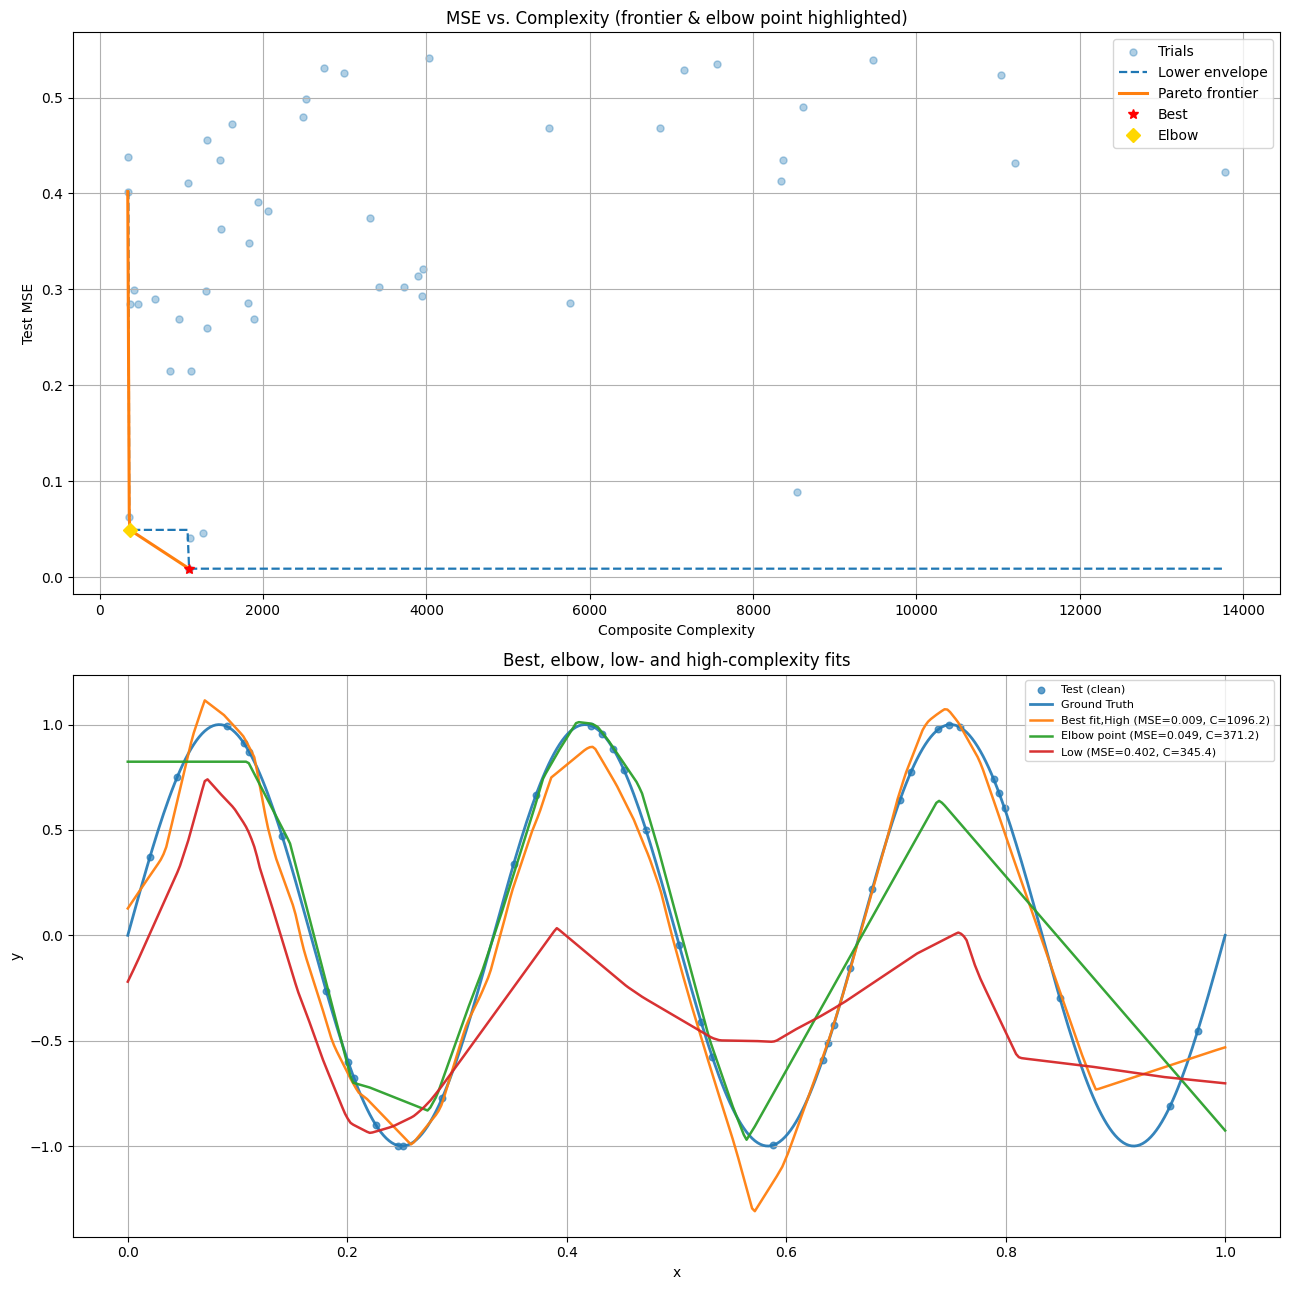

In [9]:
# === Highlight Pareto frontier & elbow point; show fits ===

losses = np.array(loss_list)
comps  = np.array(complexity_list)
best_idx = int(np.argmin(losses))
order = np.argsort(comps)
c_sorted = comps[order]
l_sorted = losses[order]

# Pareto frontier (lower envelope) w.r.t. (complexity, loss)
front_idx_sorted = []
best_so_far = np.inf
for j, l in enumerate(l_sorted):
    if l < best_so_far - 1e-12:
        best_so_far = l
        front_idx_sorted.append(j)
front_indices = order[np.array(front_idx_sorted, dtype=int)]

# Elbow point on the frontier: max distance to line between frontier endpoints
elbow_idx = best_idx
if len(front_indices) >= 3:
    cf = comps[front_indices]
    lf = losses[front_indices]
    cf_n = (cf - cf.min()) / (cf.max() - cf.min() + 1e-12)
    lf_n = (lf - lf.min()) / (lf.max() - lf.min() + 1e-12)
    x1, y1 = cf_n[0],  lf_n[0]
    x2, y2 = cf_n[-1], lf_n[-1]
    denom = np.hypot(x2 - x1, y2 - y1) + 1e-12
    dist = np.abs((y2 - y1) * cf_n - (x2 - x1) * lf_n + x2 * y1 - y2 * x1) / denom
    elbow_idx = front_indices[int(np.argmax(dist))]

# Choose models to visualize: best, elbow, lowest- and highest-complexity frontier points
low_idx  = front_indices[0]   if len(front_indices) > 0 else int(np.argmin(comps))
high_idx = front_indices[-1]  if len(front_indices) > 0 else int(np.argmax(comps))

chosen = []
for i in [best_idx, elbow_idx, low_idx, high_idx]:
    if i not in chosen:
        chosen.append(i)

# Dense x-grid for smooth curves
x_grid = np.linspace(0, 1, 400).reshape(-1, 1)
y_true = np.sin(6 * np.pi * x_grid).ravel()

# Compute prediction curves
curves, labels = [], []
for i in chosen:
    params_i, apply_i = trained_models[i]
    yhat = np.array(apply_i(params_i, jnp.array(x_grid)))
    tag = []
    if i == best_idx:  tag.append("Best fit")
    if i == elbow_idx:  tag.append("Elbow point")
    if i == low_idx:   tag.append("Low")
    if i == high_idx:  tag.append("High")
    tag = ",".join(tag) if tag else f"idx={i}"
    labels.append(f"{tag} (MSE={losses[i]:.3f}, C={comps[i]:.1f})")
    curves.append(yhat)

# --- Plot: (left) scatter + frontier + knee; (right) function fits ---
fig, axes = plt.subplots(2, 1, figsize=(13, 13))

# Left: all trials, lower envelope, frontier, best & knee
ax = axes[0]
ax.scatter(comps, losses, s=26, alpha=0.35, label='Trials')
ax.plot(c_sorted, np.minimum.accumulate(l_sorted), '--', lw=1.6, label='Lower envelope')
if len(front_indices) > 0:
    ax.plot(comps[front_indices], losses[front_indices], '-', lw=2.2, label='Pareto frontier')
ax.plot(comps[best_idx], losses[best_idx], 'r*', ms=7, label='Best')
ax.plot(comps[elbow_idx], losses[elbow_idx], 'D', ms=7, color='gold', label='Elbow')
ax.set_xlabel('Composite Complexity'); ax.set_ylabel('Test MSE')
ax.set_title('MSE vs. Complexity (frontier & elbow point highlighted)')
ax.grid(True); ax.legend()

# Right: fits of selected models against the true function and test points
ax = axes[1]
ax.scatter(x_test, y_test, s=22, alpha=0.7, label='Test (clean)')
ax.plot(x_grid, y_true, lw=2.0, alpha=0.9, label='Ground Truth')
for yhat, lab in zip(curves, labels):
    ax.plot(x_grid, yhat, lw=1.8, alpha=0.95, label=lab)
ax.set_xlabel('x'); ax.set_ylabel('y')
ax.set_title('Best, elbow, low- and high-complexity fits')
ax.grid(True); ax.legend(fontsize=8)

plt.tight_layout(); plt.show()
